# TS2Vec sur ECG5000 — Evaluation
- Rechargement d'un run existant (EXP_ID choisi à la main)
- Extraction des représentations + SVM gridsearch 
- Affichage accuracies + quelques plots sur les representations

In [1]:
import os
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import models_timestamps_masking as m

from sktime.datasets import load_from_tsfile_to_dataframe
from sklearn.linear_model import LogisticRegression
from sklearn.
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

from matplotlib.colors import ListedColormap, BoundaryNorm

## Paths + run à recharger

In [2]:
CURR_DIR = Path.cwd()
CURR_DIR_PARENT = list(CURR_DIR.parents)
SRC_DIR = CURR_DIR_PARENT[0]

DATA_DIR = SRC_DIR / "data"
DATASET_DIR = DATA_DIR / "RefrigerationDevices"
train_path = DATASET_DIR / "RefrigerationDevices_TRAIN.ts"
test_path  = DATASET_DIR / "RefrigerationDevices_TEST.ts"

RUNS_DIR = CURR_DIR / "runs"

EXP_NAME = "RefrigerationDevices_timestampMasking"

EXP_ID = "1"  

EXP_DIR = RUNS_DIR / EXP_NAME / EXP_ID
print("EXP_DIR:", EXP_DIR)

config_path = EXP_DIR / "config.json"
state_dict_path = EXP_DIR / "encoder.pt"

assert config_path.exists(), f"{config_path} not found"
assert state_dict_path.exists(), f"{state_dict_path} not found"

with open(config_path, "r") as f:
    config = json.load(f)

print("Config load:")
print(config)

EXP_DIR: /home/infres/rplanchon-23/code/TS2VEC/T2SVEC/src/first_Imple/runs/RefrigerationDevices_timestampMasking/1
Config load:
{'dataset': 'FRIDGE', 'in_channel': 1, 'representation_dim': 320, 'num_blocks': 10, 'kernel_size': 3, 'lr': 0.0001, 'batch_size': 8, 'n_epoch': 500, 'alpha': 0.5, 'temporal_unit': 0, 'use_instance_loss': True, 'use_time_loss': True}


## Data 

In [ ]:
X_train, y_train = load_from_tsfile_to_dataframe(str(train_path))
X_test,  y_test  = load_from_tsfile_to_dataframe(str(test_path))

print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)
print("Example series shape:", X_train.iloc[0, 0].shape)

def df_to_numpy(X):
    arr = np.stack([X.iloc[i, 0] for i in range(len(X))], axis=0)
    return arr[..., np.newaxis]  # (N, T, 1)

X_train_np = df_to_numpy(X_train)
X_test_np  = df_to_numpy(X_test)

X_train_torch = torch.from_numpy(X_train_np).float()
X_test_torch  = torch.from_numpy(X_test_np).float()
y_train_torch = torch.from_numpy(y_train.astype(np.int64))
y_test_torch  = torch.from_numpy(y_test.astype(np.int64))

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset  = TensorDataset(X_test_torch,  y_test_torch)

train_eval_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_eval_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

# data loader pour la visualisation (les series sont ordonnés par classes donc on avait besoin de dataloader shuffler)
train_viz_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_viz_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=True)

X_train shape: (375, 1)
X_test shape : (375, 1)
Example series shape: (720,)


## Modèle laoding

In [4]:
device = "mps" if torch.mps.is_available() else "cpu"
print("Device:", device)

model = m.Encoder(
    in_channel=config["in_channel"],
    representation_dim=config["representation_dim"],
    num_blocks=config["num_blocks"],
    kernel_size=config["kernel_size"],
)
model.load_state_dict(torch.load(state_dict_path, map_location=device))
model.to(device)
model.eval()

total = sum(p.numel() for p in model.parameters())
print(f"Total params: {total/1e6:.2f} M")

Device: cpu


Total params: 6.15 M


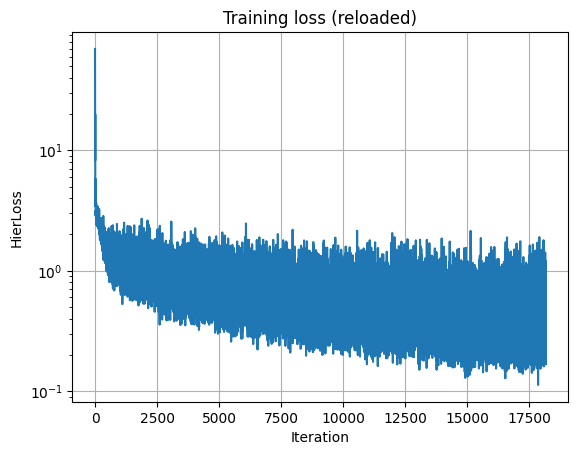

In [5]:
loss_path = EXP_DIR / "train_loss.npy"
if loss_path.exists():
    log_np = np.load(loss_path)
    plt.figure()
    plt.plot(log_np)
    plt.yscale("log")
    plt.title("Training loss (reloaded)")
    plt.xlabel("Iteration")
    plt.ylabel("HierLoss")
    plt.grid(True)
    plt.show()
else:
    print("No train_loss.npy found at", loss_path)

## Extraction des représentations + logistic regression

In [6]:
@torch.no_grad()
def extract_representations(dataloader, model, device):
    zs = []
    ys = []
    for x, y in dataloader:
        # x: (B, T, 1) -> (B, 1, T)
        x = x.to(device).permute(0, 2, 1)

        # (B, K, T)
        r = model(x)  
 
        z = r.max(dim=-1).values 
      
        zs.append(z.cpu())
        ys.append(y.cpu())

    Z = torch.cat(zs, dim=0).numpy() # (N, K)
    y = torch.cat(ys, dim=0).numpy()# (N,)
    return Z, y

Z_train, y_train_np = extract_representations(train_eval_loader, model, device)
Z_test,  y_test_np  = extract_representations(test_eval_loader,  model, device)

print("Z_train/Z_test shapes:", Z_train.shape, Z_test.shape)

Z_train / Z_test shapes: (375, 320) (375, 320)


### Classificatioin sur la representation instance level 
    On fait comme décrit dans le papier : SVM avec un grid search sur C.

In [30]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


Cs = [10.0**i for i in range(-4, 5)] + [1e6]  

param_grid = {
    "C": Cs, 
}

# SVM avec noyau RBF
base_svm = SVC(kernel="rbf")  

# Grid-search avec cross-validation sur le training set
clf = GridSearchCV(estimator=base_svm,param_grid=param_grid,cv=5,         n_jobs=-1,   verbose=0)
clf.fit(Z_train, y_train_np)

print("Best C found by CV:", clf.best_params_["C"])

# Meilleur modèle trouvé
best_svm = clf.best_estimator_

# Évaluation train/test
y_pred_train = best_svm.predict(Z_train)
y_pred_test  = best_svm.predict(Z_test)

acc_train = accuracy_score(y_train_np, y_pred_train)
acc_test  = accuracy_score(y_test_np,y_pred_test)

print(f"Train accuracy: {acc_train}")
print(f"Test accuracy: {acc_test}")


Best C found by CV: 0.0001
Train accuracy: 0.6773333333333333
Test accuracy: 0.5786666666666667


## Visualisation rapide des features

out shape: torch.Size([32, 320, 720])
x_batch shape: torch.Size([32, 720, 1])


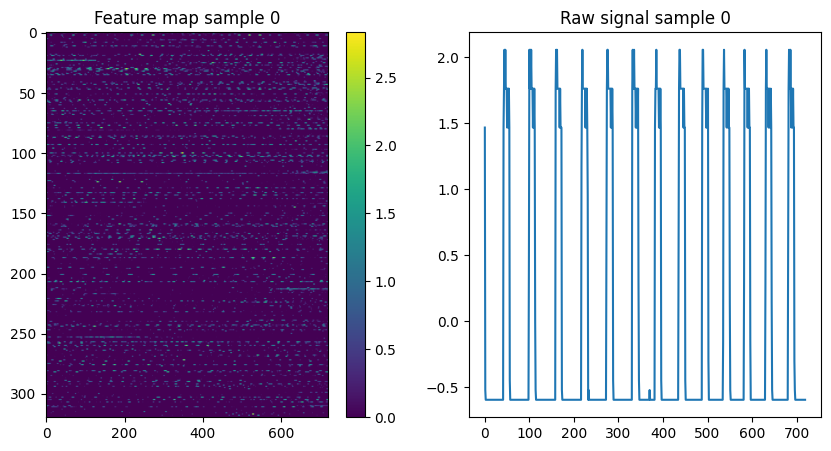

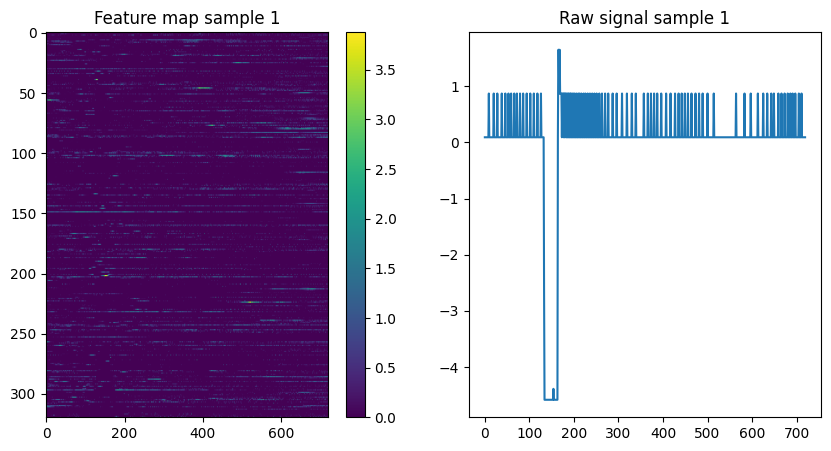

In [18]:
iterative = iter(train_viz_loader)
x_batch,_ = next(iterative)
x_batch = x_batch.to(device)
out = model(x_batch.permute(0, 2, 1))
B,_, _ = out.shape
print("out shape:", out.shape)
print("x_batch shape:", x_batch.shape)

for j in range(min(B, 2)):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(out[j].squeeze().cpu().detach(), aspect="auto")
    plt.colorbar()
    plt.title(f"Feature map sample {j}")
    plt.subplot(1,2,2)
    plt.plot(x_batch[j].view(-1).cpu().detach())
    plt.title(f"Raw signal sample {j}")
    plt.show()

In [22]:
@torch.no_grad()
def visualize_ts2vec_heatmap(model, dataloader, device, n_dims=16, sampleidx=0):
    model.eval()
    
    x_batch, y_batch = next(iter(dataloader))   # (B, T, 1)
    x_batch = x_batch.to(device)
    x = x_batch[sampleidx]                      # (T, 1)
    
    # Passage dans le modèle
    r = model(x.unsqueeze(0).permute(0, 2, 1))  # (1, K, T)
    r = r[0].cpu().numpy()                      # (K, T)
    K, T = r.shape

    # Sécurité si n_dims>K
    n_dims_eff = min(n_dims, K)

    # On garde les features avec la plus grande variance
    var_per_dim = r.var(axis=1)                          # (K,)
    idx = np.argsort(var_per_dim)[-n_dims_eff:]          # top-n_dims
    r_sel = r[idx, :]                                # (n_dims_eff, T)

    # Normalisation par dimension
    mean = r_sel.mean(axis=1, keepdims=True)
    std = r_sel.std(axis=1, keepdims=True) + 1e-8
    r_norm = (r_sel - mean) / std              # (n_dims_eff, T)

    fig,axs = plt.subplots(2, 1,figsize=(10, 6),sharex=True,gridspec_kw={"height_ratios": [1, 2]},constrained_layout=True,)

    # Signal brut
    axs[0].plot(x.cpu().view(-1).numpy())
    axs[0].set_title(f"Raw signal (sample {sampleidx})")
    axs[0].grid(True, alpha=0.2)

    # hteatmap aligné avec le signal
    im = axs[1].imshow(r_norm, aspect="auto", interpolation="nearest")
    axs[1].set_ylabel("Feature dim (top variance)")
    axs[1].set_xlabel("Time")
    axs[1].set_yticks(range(n_dims_eff))
    axs[1].set_yticklabels(idx)

    fig.colorbar(im, ax=axs, fraction=0.03, pad=0.02, label="normalized value")

    plt.show()


In [27]:
def visualize_ts2vec_tsne(Z, y, n_samples=2000, perplexity=30.0):
    # Sous-échantillonnage si trop de points
    Z = np.asarray(Z)
    y = np.asarray(y)

    if Z.shape[0] > n_samples:
        idx = np.random.choice(Z.shape[0], size=n_samples, replace=False)
        Z = Z[idx]
        y = y[idx]

    classes = np.unique(y)
    n_classes = len(classes)
    class_to_idx = {c: i for i, c in enumerate(classes)}
    y_int = np.vectorize(class_to_idx.get)(y)

    # T-sne
    tsne = TSNE(n_components=2,perplexity=perplexity,init="random",learning_rate="auto",)
    Z_2d = tsne.fit_transform(Z) # (N, 2)

    base_cmap = plt.get_cmap("tab10")  
    colors = base_cmap.colors[:n_classes] 
    cmap = ListedColormap(colors)

    bounds = np.arange(-0.5, n_classes + 0.5, 1.0)
    norm = BoundaryNorm(bounds, n_classes)

    plt.figure(figsize=(7, 6))
    scatter = plt.scatter(Z_2d[:, 0],Z_2d[:, 1],c=y_int,s=5,alpha=0.8,cmap=cmap,norm=norm,
    )
    plt.title("t-SNE of instance-level representations (max-pooled)")
    plt.xlabel("dim 1")
    plt.ylabel("dim 2")

    # Colorbar discrète, avec les vraies classes en label
    cbar = plt.colorbar(scatter, ticks=np.arange(n_classes))
    cbar.ax.set_yticklabels(classes.astype(str))
    cbar.set_label("class")

    plt.tight_layout()
    plt.show()


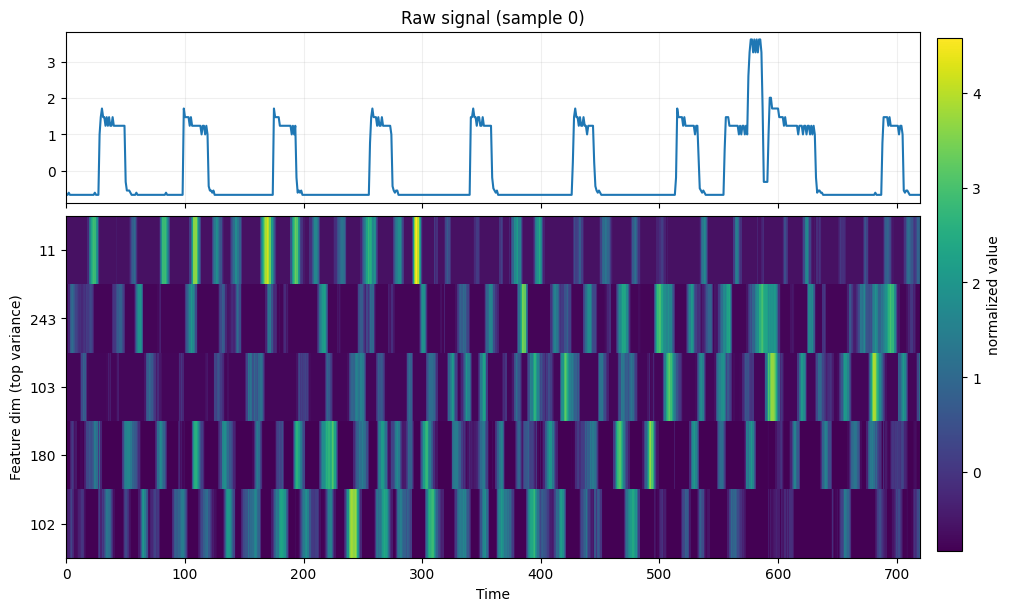

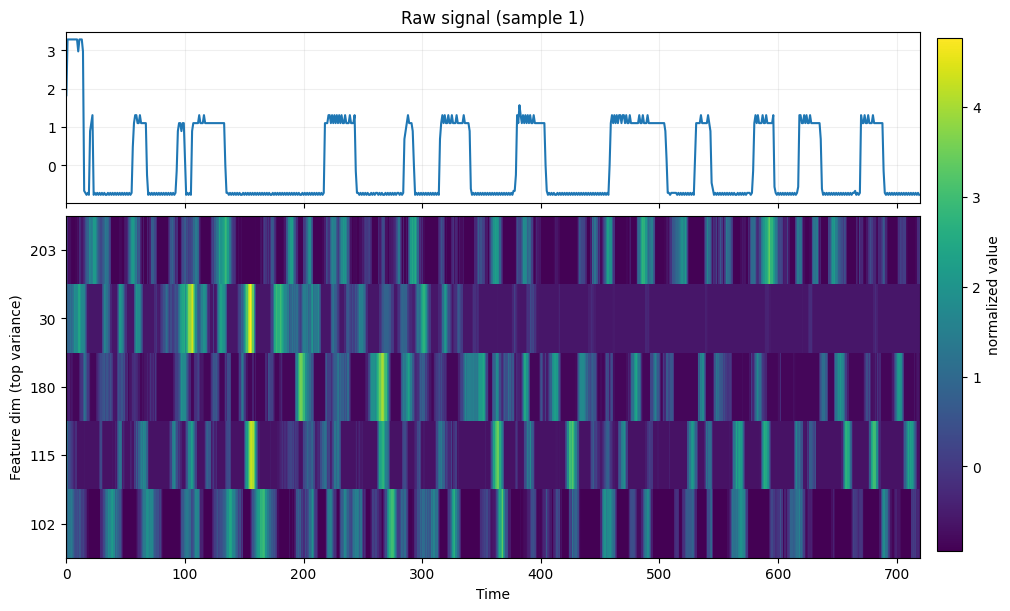

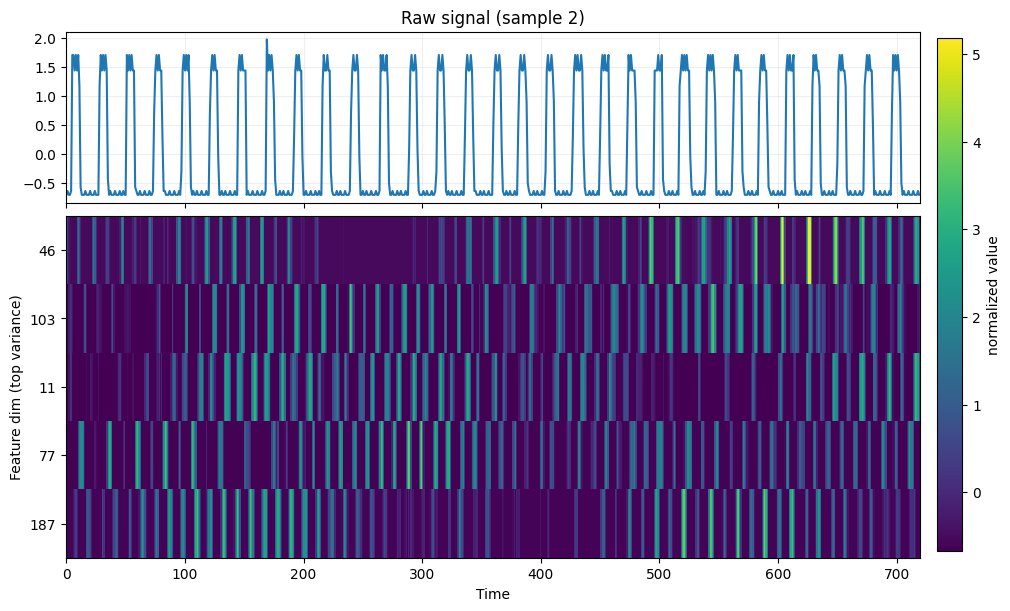

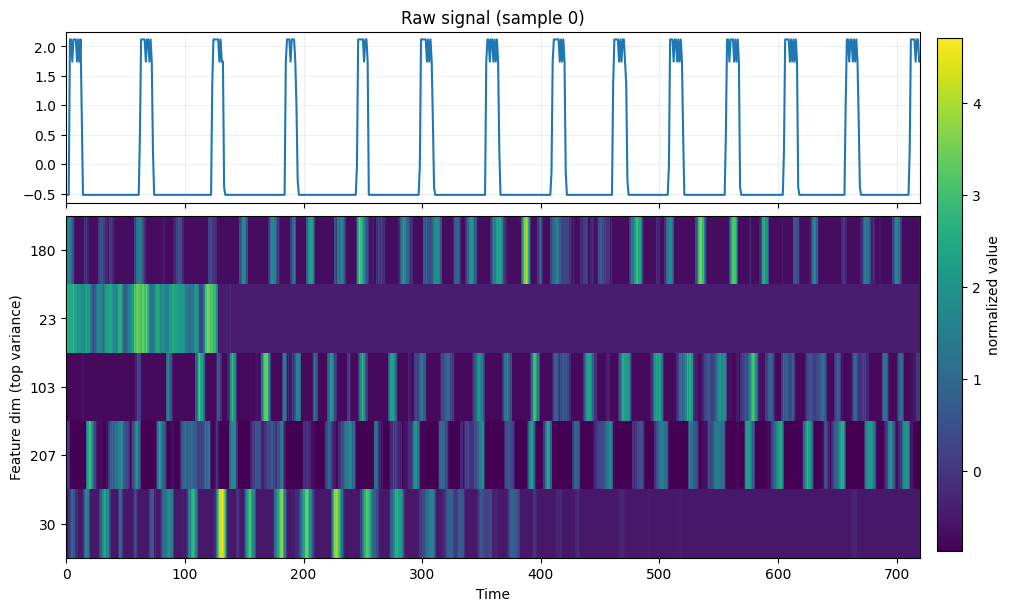

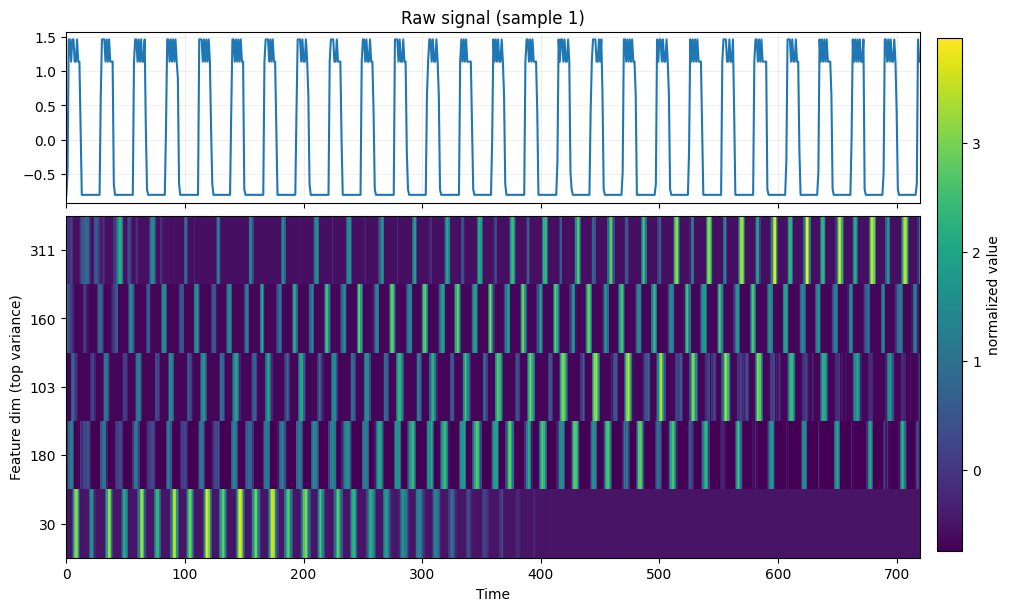

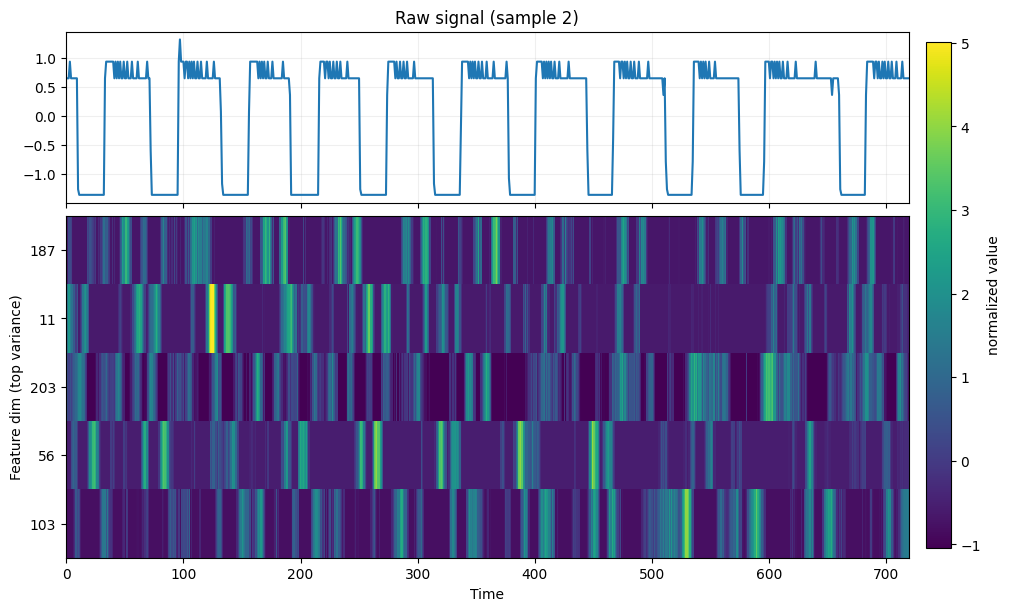

Classes trouvées dans y : [1 2 3]  (nb = 3 )


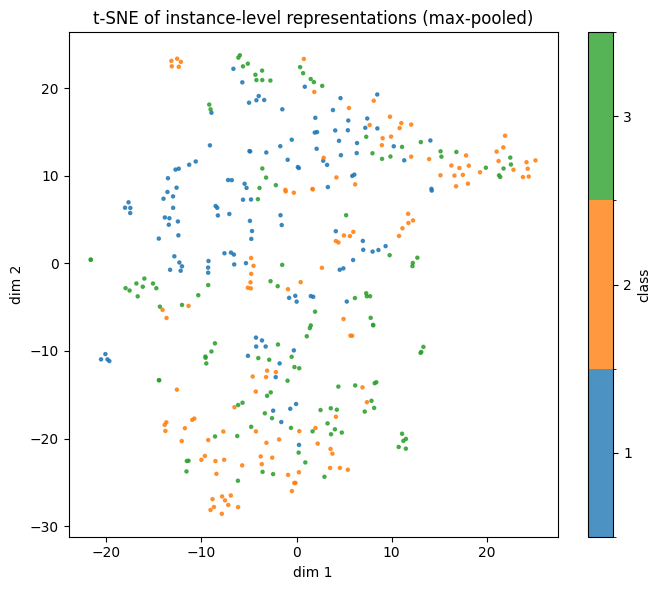

In [28]:
model.eval()

# visualisation heatmap sur le train
for idx in range(3):  
    visualize_ts2vec_heatmap(model=model,dataloader=train_viz_loader,device=device,n_dims=5,sampleidx=idx)

# pareil sur le test
for idx in range(3):
    visualize_ts2vec_heatmap(model=model,dataloader=test_viz_loader,device=device,n_dims=5,sampleidx=idx,)

In [ ]:

visualize_ts2vec_tsne(Z=Z_train,y=y_train_np,n_samples=2000, perplexity=30.0)
